In [7]:
pwd

'/content'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/Rakuten_for_colab/image_train_zoomed.zip /content/

!mkdir -p /content/image_train_zoomed
# Unzip into it
!unzip -q /content/image_train_zoomed.zip -d /content/image_train_zoomed/

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetB0, ConvNeXtTiny
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
#import tensorflow_addons as tfa
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
import time

In [5]:
df_train_balanced = pd.read_csv("drive/MyDrive/Rakuten_for_colab/input_data/df_train_balanced.csv")
val_df = pd.read_csv("drive/MyDrive/Rakuten_for_colab/input_data/val_df.csv")
num_classes = df_train_balanced["label"].nunique()
num_classes

27

In [5]:
df_train_balanced.head()

,designation,description,productid,imageid,content_ratio,prdtypecode,label,augmented
0,Magnet Père Dodu - Régions D'europe - 48 - Orl...,NaN,73192148,844757331,0.666000,1140,4,False
1,Lot De 3 Revues Aquarium Magazine Et 1 Aquariu...,NaN,3744929595,1240241895,0.860000,2403,19,False
2,Living Room Dressing Table Desktop Sundries St...,Living Room Dressing Table Desktop Sundries St...,4057530663,1282883250,1.000000,1560,13,False
3,Rc280 Telecommande Pour Tcl Roku Tlc Tv 40fs37...,Description: <br />Type d&#39;element: Teleco...,4108382685,1292292689,0.611184,50,2,False
4,Tout-petit bébé Enfants 15pc Chaussettes bébé ...,Tout-petit bébé Enfants 15pc Chaussettes bébé ...,3898729891,1261430706,0.676396,1301,10,True


## Verify all images are present

In [ ]:

image_dir = 'drive/MyDrive/Rakuten_for_colab/image_train_zoomed/'

df_train_balanced['image_exists'] = False

for index, row in df_train_balanced.iterrows():
    image_id = row['imageid']
    product_id = row['productid']
    image_filename = f"image_{image_id}_product_{product_id}.jpg"
    image_path = os.path.join(image_dir, image_filename)

    if os.path.exists(image_path):
        df_train_balanced.at[index, 'image_exists'] = True

print("Number of rows with images:", df_train_balanced['image_exists'].sum())

missing_images = df_train_balanced[~df_train_balanced['image_exists']]
print("Rows with missing images:")
print(missing_images)

Number of rows with images: 71199
Rows with missing images:
Empty DataFrame
Columns: [designation, description, productid, imageid, content_ratio, prdtypecode, label, augmented, image_exists]
Index: []


In [7]:
val_df['image_exists'] = False
for index, row in val_df.iterrows():
    image_id = row['imageid']
    product_id = row['productid']
    image_filename = f"image_{image_id}_product_{product_id}.jpg"
    image_path = os.path.join(image_dir, image_filename)

    # Check if the image file exists
    if os.path.exists(image_path):
        val_df.at[index, 'image_exists'] = True

# You can now check the 'image_exists' column
# To see how many rows have a corresponding image:
print("Number of rows with images:", val_df['image_exists'].sum())

# To see rows that do not have an image:
missing_images = val_df[~val_df['image_exists']]
print("Rows with missing images:")
print(missing_images)

Number of rows with images: 16902
Rows with missing images:
Empty DataFrame
Columns: [designation, description, productid, imageid, content_ratio, prdtypecode, label, image_exists]
Index: []


In [11]:
base_path = "/content/image_train_zoomed/"

## Helper functions

In [20]:
def plot_history(history_dict):
    epochs = range(1, len(history_dict['loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    ax1.plot(epochs, history_dict['loss'], label='Train Loss')
    ax1.plot(epochs, history_dict['val_loss'], label='Val Loss')
    ax1.set_title('Loss over Epochs', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.legend(fontsize=14)

    # Plot Accuracy
    ax2.plot(epochs, history_dict['sparse_categorical_accuracy'], label='Train Accuracy')
    ax2.plot(epochs, history_dict['val_sparse_categorical_accuracy'], label='Val Accuracy')
    ax2.set_title('Accuracy over Epochs', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=14)
    ax2.set_ylabel('Accuracy', fontsize=14)
    ax2.legend(fontsize=14)

    plt.tight_layout()
    plt.show()


In [24]:
from sklearn.metrics import classification_report

def evaluate_model(model, val_ds):
    y_true = []
    y_pred = []

    for images, labels in val_ds:
        # Predict on the batch
        preds = model.predict(images, verbose=0)

        # Convert predictions to class indices
        batch_pred = np.argmax(preds, axis=1)

        # Convert true labels to class indices
        if len(labels.shape) > 1 and labels.shape[1] > 1:
            batch_true = np.argmax(labels.numpy(), axis=1)
        else:
            batch_true = labels.numpy()

        y_pred.extend(batch_pred)
        y_true.extend(batch_true)

    # Convert to arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Generate class names
    num_classes = model.output_shape[-1]
    class_names = [f'class_{i}' for i in range(num_classes)]

    # Print classification report
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)

In [36]:

def plot_history_comp(model1, model2, model1_name="Model 1", model2_name="Model 2"):
    history1 = model1.history.history
    history2 = model2.history.history

    # Plot Loss
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history1['loss'], label=f'{model1_name} - Train')
    plt.plot(history1['val_loss'], label=f'{model1_name} - Val')
    plt.plot(history2['loss'], label=f'{model2_name} - Train')
    plt.plot(history2['val_loss'], label=f'{model2_name} - Val')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history1['sparse_categorical_accuracy'], label=f'{model1_name} - Train')
    plt.plot(history1['val_sparse_categorical_accuracy'], label=f'{model1_name} - Val')
    plt.plot(history2['sparse_categorical_accuracy'], label=f'{model2_name} - Train')
    plt.plot(history2['val_sparse_categorical_accuracy'], label=f'{model2_name} - Val')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


## EfficientNetB0

In [ ]:
def create_datasets(base_path, train_df, val_df, batch_size):
    def preprocess_image(imageid, productid, label, augmented):
        def _load_image(image_path):
            img = tf.io.read_file(image_path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, [224, 224])
            img = tf.keras.applications.efficientnet.preprocess_input(img)
            return img

        image_path = tf.strings.join([
            base_path,
            "image_",
            imageid,
            "_product_",
            productid,
            ".jpg"
        ])

        image = _load_image(image_path)

        def apply_augmentation(img):
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, max_delta=0.1)
            translations = tf.cast(tf.random.uniform([2], -10, 10), tf.int32)
            img = tf.roll(img, shift=translations[0], axis=0)  
            img = tf.roll(img, shift=translations[1], axis=1)  
            return img

        image = tf.cond(augmented, lambda: apply_augmentation(image), lambda: image)

        return image, label

    # Prepare train dataset with augmentation flags from train_df
    train_image_ids = train_df["imageid"].astype(str).values
    train_product_ids = train_df["productid"].astype(str).values
    train_labels = train_df["label"].values
    train_aug_flags = train_df["augmented"].astype(bool).values

    train_ds = tf.data.Dataset.from_tensor_slices(
        (train_image_ids, train_product_ids, train_labels, train_aug_flags)
    )
    train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Prepare validation dataset (no augmentation)
    val_image_ids = val_df["imageid"].astype(str).values
    val_product_ids = val_df["productid"].astype(str).values
    val_labels = val_df["label"].values
    val_aug_flags = [False] * len(val_df)

    val_ds = tf.data.Dataset.from_tensor_slices(
        (val_image_ids, val_product_ids, val_labels, val_aug_flags)
    )
    val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds

In [ ]:
train_ds, val_ds = create_datasets(base_path, df_train_balanced, val_df, 128)

In [ ]:
# Model definition
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

#for layer in base_model.layers[-5:]:
#    if not isinstance(layer, tf.keras.layers.BatchNormalization):
#        layer.trainable = True

efficientnetb0_b128l0 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

efficientnetb0_b128l0.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

#Callbacks

checkpoint = ModelCheckpoint(
    'efficientnetb0_b128l0_best_model.keras',                
    monitor='val_loss',             
    mode='min',                    
    save_best_only=True,           
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.02,
    restore_best_weights=True
)

learning_rate =  ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=1,
        min_delta=0.1,
        min_lr=1e-7,
        verbose=1
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
start_time = time.time()

efficientnetb0_b128l0_history = efficientnetb0_b128l0.fit(train_ds,
          validation_data=val_ds,
          epochs=20,
          callbacks=[early_stop, checkpoint, learning_rate])

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_min = elapsed_time / 60
print(f"Training time: {elapsed_time_min:.2f} min")

Epoch 1/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 6.6274 - sparse_categorical_accuracy: 0.0855
Epoch 1: val_loss improved from inf to 4.89336, saving model to efficientnetb0_b128l0_best_model.keras
557/557 ━━━━━━━━━━━━━━━━━━━━ 84s 109ms/step - loss: 6.6264 - sparse_categorical_accuracy: 0.0856 - val_loss: 4.8934 - val_sparse_categorical_accuracy: 0.3649 - learning_rate: 1.0000e-04
Epoch 2/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.9403 - sparse_categorical_accuracy: 0.2461
Epoch 2: val_loss improved from 4.89336 to 3.92187, saving model to efficientnetb0_b128l0_best_model.keras
557/557 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - loss: 4.9399 - sparse_categorical_accuracy: 0.2462 - val_loss: 3.9219 - val_sparse_categorical_accuracy: 0.4294 - learning_rate: 1.0000e-04
Epoch 3/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.0629 - sparse_categorical_accuracy: 0.3266
Epoch 3: val_loss improved from 3.92187 to 3.28661, saving model to efficientnetb0_b128l0_best_model.

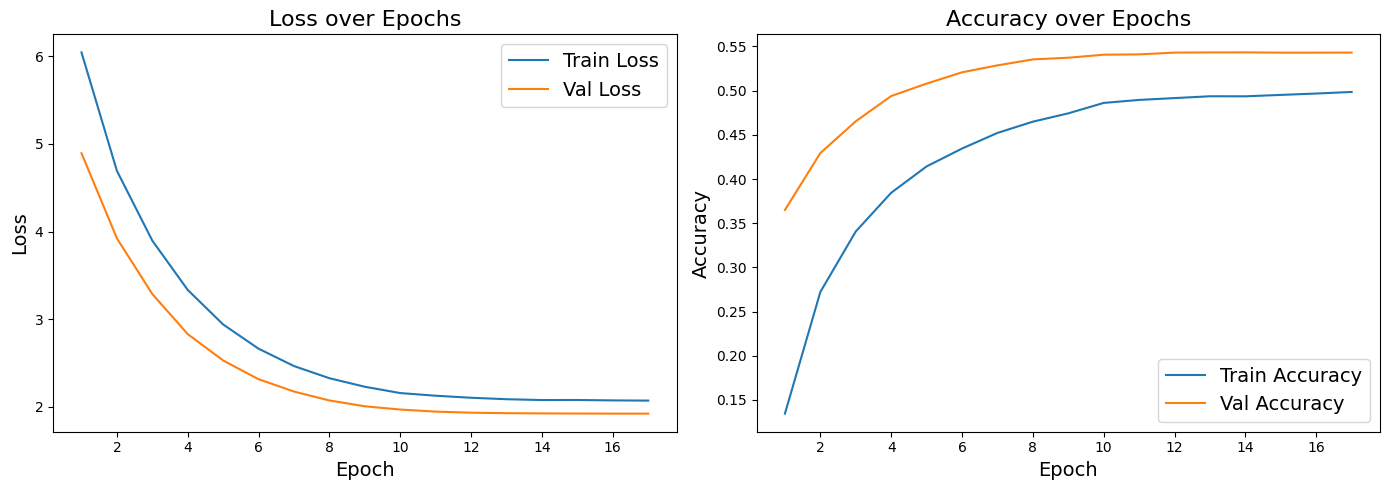

In [22]:
plot_history(efficientnetb0_b128l0_history.history)

In [ ]:
evaluate_model(efficientnetb0_b128l0, val_ds)

              precision    recall  f1-score   support

     class_0       0.39      0.33      0.35       622
     class_1       0.52      0.41      0.46       498
     class_2       0.29      0.41      0.34       334
     class_3       0.43      0.80      0.56       166
     class_4       0.55      0.65      0.59       527
     class_5       0.87      0.86      0.87       786
     class_6       0.27      0.42      0.33       151
     class_7       0.48      0.21      0.29       973
     class_8       0.31      0.21      0.25       413
     class_9       0.60      0.61      0.61      1007
    class_10       0.36      0.77      0.49       157
    class_11       0.33      0.35      0.34       496
    class_12       0.41      0.39      0.40       643
    class_13       0.63      0.51      0.57      1014
    class_14       0.79      0.77      0.78       860
    class_15       0.37      0.81      0.51       159
    class_16       0.53      0.43      0.47       998
    class_17       0.24    

## EfficientNetB0 L5

In [ ]:
# Model definition
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

for layer in base_model.layers[-5:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

efficientnetb0_b128l5 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

efficientnetb0_b128l5.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Callbacks

checkpoint = ModelCheckpoint(
    'efficientnetb0_b128l5_best_model.keras',               
    monitor='val_loss',            
    mode='min',                   
    save_best_only=True,            
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.02,
    restore_best_weights=True
)

learning_rate =  ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=1,
        min_delta=0.1,
        min_lr=1e-7,
        verbose=1
)


In [ ]:
start_time = time.time()

efficientnetb0_b128l5_history = efficientnetb0_b128l5.fit(train_ds,
          validation_data=val_ds,
          epochs=20,
          callbacks=[early_stop, checkpoint, learning_rate])

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_min = elapsed_time / 60
print(f"Training time: {elapsed_time_min:.2f} min")

Epoch 1/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 6.2996 - sparse_categorical_accuracy: 0.1222
Epoch 1: val_loss improved from inf to 4.52496, saving model to efficientnetb0_b128l5_best_model.keras
557/557 ━━━━━━━━━━━━━━━━━━━━ 70s 87ms/step - loss: 6.2986 - sparse_categorical_accuracy: 0.1223 - val_loss: 4.5250 - val_sparse_categorical_accuracy: 0.4440 - learning_rate: 1.0000e-04
Epoch 2/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.6205 - sparse_categorical_accuracy: 0.3258
Epoch 2: val_loss improved from 4.52496 to 3.62370, saving model to efficientnetb0_b128l5_best_model.keras
557/557 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - loss: 4.6201 - sparse_categorical_accuracy: 0.3258 - val_loss: 3.6237 - val_sparse_categorical_accuracy: 0.5020 - learning_rate: 1.0000e-04
Epoch 3/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.7787 - sparse_categorical_accuracy: 0.4010
Epoch 3: val_loss improved from 3.62370 to 3.03950, saving model to efficientnetb0_b128l5_best_model.k

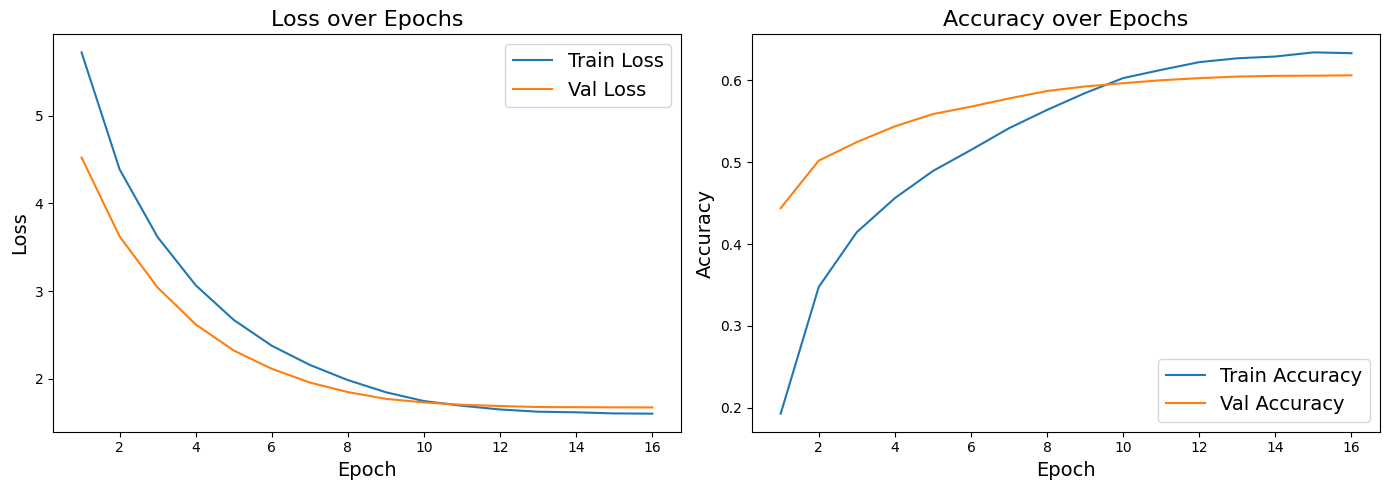

In [29]:
plot_history(efficientnetb0_b128l5_history.history)

## EfficientNetB0 L5 LR

In [ ]:
# Model definition
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

for layer in base_model.layers[-5:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

efficientnetb0_b128l5lr = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

efficientnetb0_b128l5lr.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Callbacks

checkpoint = ModelCheckpoint(
    'efficientnetb0_b128l5lr_best_model.keras',               
    monitor='val_loss',             
    mode='min',                     
    save_best_only=True,            
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.02,
    restore_best_weights=True
)

learning_rate =  ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=1,
        min_delta=0.05,
        min_lr=1e-7,
        verbose=1
)


In [ ]:
start_time = time.time()

efficientnetb0_b128l5lr_history = efficientnetb0_b128l5lr.fit(train_ds,
          validation_data=val_ds,
          epochs=20,
          callbacks=[early_stop, checkpoint, learning_rate])

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_min = elapsed_time / 60
print(f"Training time: {elapsed_time_min:.2f} min")

Epoch 1/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 6.3735 - sparse_categorical_accuracy: 0.1211
Epoch 1: val_loss improved from inf to 4.56119, saving model to efficientnetb0_b128l5lr_best_model.keras
557/557 ━━━━━━━━━━━━━━━━━━━━ 70s 87ms/step - loss: 6.3724 - sparse_categorical_accuracy: 0.1212 - val_loss: 4.5612 - val_sparse_categorical_accuracy: 0.4308 - learning_rate: 1.0000e-04
Epoch 2/20
556/557 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.6528 - sparse_categorical_accuracy: 0.3241
Epoch 2: val_loss improved from 4.56119 to 3.67854, saving model to efficientnetb0_b128l5lr_best_model.keras
557/557 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - loss: 4.6520 - sparse_categorical_accuracy: 0.3242 - val_loss: 3.6785 - val_sparse_categorical_accuracy: 0.4904 - learning_rate: 1.0000e-04
Epoch 3/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.8198 - sparse_categorical_accuracy: 0.3960
Epoch 3: val_loss improved from 3.67854 to 3.09310, saving model to efficientnetb0_b128l5lr_best_m

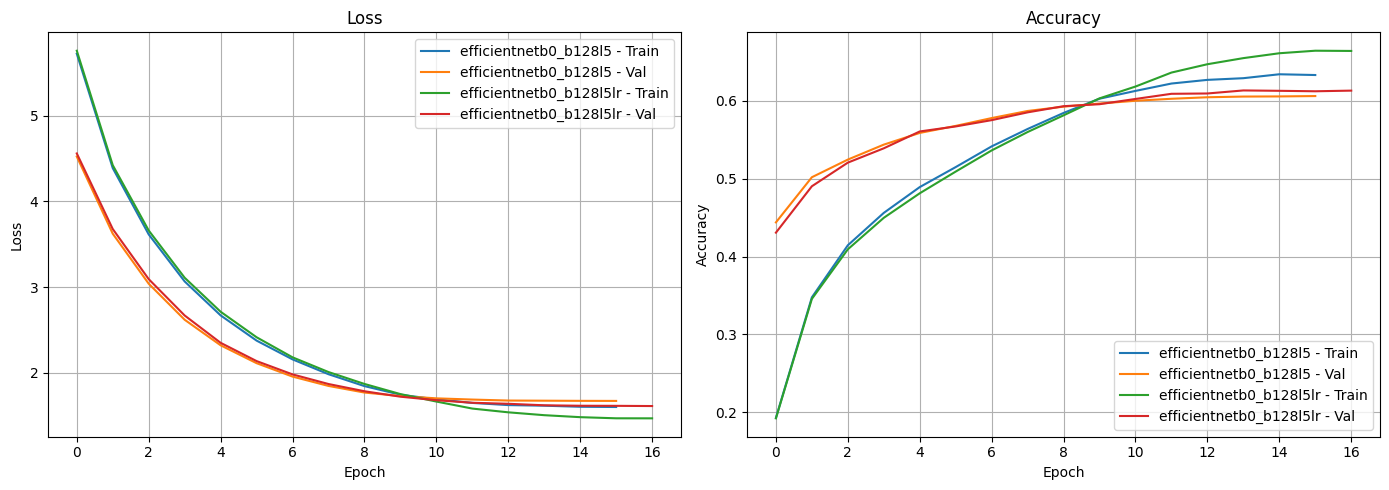

In [37]:
plot_history_comp(efficientnetb0_b128l5, efficientnetb0_b128l5lr,
                      model1_name="efficientnetb0_b128l5",
                      model2_name="efficientnetb0_b128l5lr")

## EfficientNetB0 L10

In [ ]:
# Model definition
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

for layer in base_model.layers[-10:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

efficientnetb0_b128l10 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

efficientnetb0_b128l10.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Callbacks

checkpoint = ModelCheckpoint(
    'efficientnetb0_b128l10_best_model.keras',               
    monitor='val_loss',            
    mode='min',                     
    save_best_only=True,            
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.02,
    restore_best_weights=True
)

learning_rate =  ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=1,
        min_delta=0.1,
        min_lr=1e-7,
        verbose=1
)


In [ ]:
start_time = time.time()

efficientnetb0_b128l10_history = efficientnetb0_b128l10.fit(train_ds,
          validation_data=val_ds,
          epochs=20,
          callbacks=[early_stop, checkpoint, learning_rate])

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_min = elapsed_time / 60
print(f"Training time: {elapsed_time_min:.2f} min")

Epoch 1/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 6.3375 - sparse_categorical_accuracy: 0.1269
Epoch 1: val_loss improved from inf to 4.54965, saving model to efficientnetb0_b128l10_best_model.keras
557/557 ━━━━━━━━━━━━━━━━━━━━ 72s 90ms/step - loss: 6.3365 - sparse_categorical_accuracy: 0.1270 - val_loss: 4.5497 - val_sparse_categorical_accuracy: 0.4373 - learning_rate: 1.0000e-04
Epoch 2/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.6585 - sparse_categorical_accuracy: 0.3261
Epoch 2: val_loss improved from 4.54965 to 3.68324, saving model to efficientnetb0_b128l10_best_model.keras
557/557 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - loss: 4.6581 - sparse_categorical_accuracy: 0.3262 - val_loss: 3.6832 - val_sparse_categorical_accuracy: 0.4904 - learning_rate: 1.0000e-04
Epoch 3/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.8046 - sparse_categorical_accuracy: 0.3987
Epoch 3: val_loss improved from 3.68324 to 3.07900, saving model to efficientnetb0_b128l10_best_mode

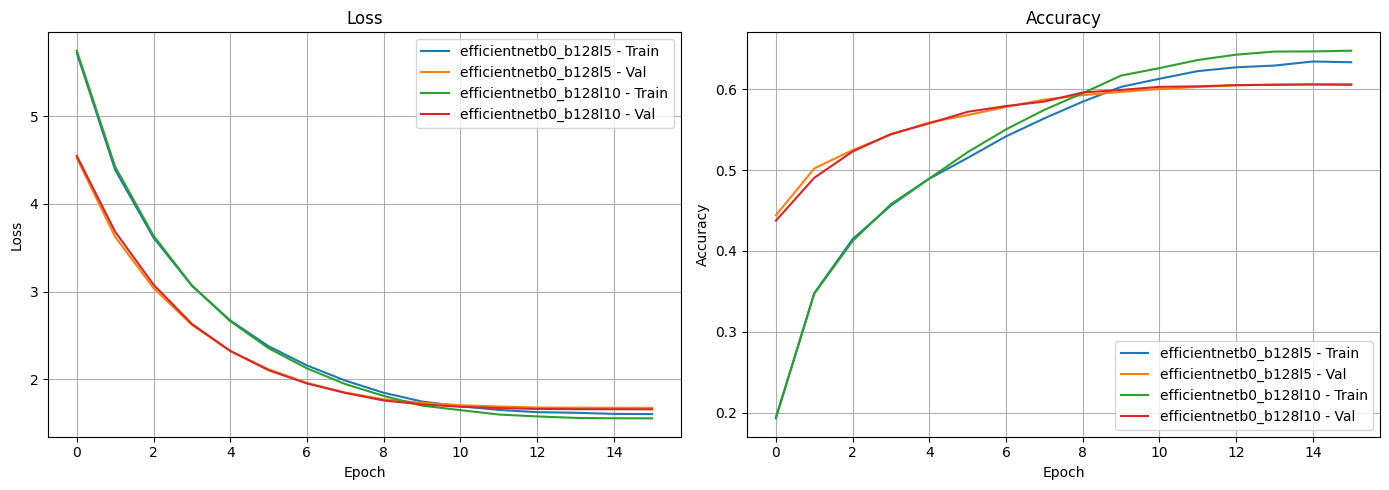

In [40]:
plot_history_comp(efficientnetb0_b128l5, efficientnetb0_b128l10,
                      model1_name="efficientnetb0_b128l5",
                      model2_name="efficientnetb0_b128l10")

## ConvnextTiny L5

In [41]:
def create_datasets_convnext(base_path, train_df, val_df, batch_size):
    def preprocess_image(imageid, productid, label, augmented):
        def _load_image(image_path):
            img = tf.io.read_file(image_path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, [224, 224])
            img = tf.keras.applications.convnext.preprocess_input(img)
            return img

        image_path = tf.strings.join([
            base_path,
            "image_",
            imageid,
            "_product_",
            productid,
            ".jpg"
        ])

        image = _load_image(image_path)

        def apply_augmentation(img):
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, max_delta=0.1)
            translations = tf.cast(tf.random.uniform([2], -10, 10), tf.int32)
            img = tf.roll(img, shift=translations[0], axis=0)  # vertical shift
            img = tf.roll(img, shift=translations[1], axis=1)  # horizontal shift
            return img

        image = tf.cond(augmented, lambda: apply_augmentation(image), lambda: image)

        return image, label

    # Prepare train dataset with augmentation flags from train_df
    train_image_ids = train_df["imageid"].astype(str).values
    train_product_ids = train_df["productid"].astype(str).values
    train_labels = train_df["label"].values
    train_aug_flags = train_df["augmented"].astype(bool).values

    train_ds = tf.data.Dataset.from_tensor_slices(
        (train_image_ids, train_product_ids, train_labels, train_aug_flags)
    )
    train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Prepare validation dataset (no augmentation)
    val_image_ids = val_df["imageid"].astype(str).values
    val_product_ids = val_df["productid"].astype(str).values
    val_labels = val_df["label"].values
    val_aug_flags = [False] * len(val_df)

    val_ds = tf.data.Dataset.from_tensor_slices(
        (val_image_ids, val_product_ids, val_labels, val_aug_flags)
    )
    val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds

In [42]:
train_ds, val_ds = create_datasets_convnext(base_path, df_train_balanced, val_df, 128)

In [ ]:
# Model definition
base_model = ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

for layer in base_model.layers[-5:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

convnexttiny_l5 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

convnexttiny_l5.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Callbacks

checkpoint = ModelCheckpoint(
    'convnexttiny_l5_best_model.keras',               
    monitor='val_loss',            
    mode='min',                    
    save_best_only=True,            
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.02,
    restore_best_weights=True
)

learning_rate =  ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=1,
        min_delta=0.1,
        min_lr=1e-7,
        verbose=1
)

In [44]:
print("Model architecture:")
convnexttiny_l5.summary()

Model architecture:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_tiny (Functional)      │ (None, 7, 7, 768)      │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 768)            │         3,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 27)             │         1,755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,931,643 (106.55 MB)

 Trainable params: 2,472,347 (9.43 MB)

 Non-trainable params: 25,459,296 (97.12 MB)

In [ ]:
import time
start_time = time.time()

convnexttiny_l5_history = convnexttiny_l5.fit(train_ds,
          validation_data=val_ds,
          epochs=20,
          callbacks=[early_stop, checkpoint, learning_rate])

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_min = elapsed_time / 60
print(f"Training time: {elapsed_time_min:.2f} min")

Epoch 1/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 6.3206 - sparse_categorical_accuracy: 0.1038
Epoch 1: val_loss improved from inf to 4.74973, saving model to convnexttiny_l5_best_model.keras
557/557 ━━━━━━━━━━━━━━━━━━━━ 85s 123ms/step - loss: 6.3196 - sparse_categorical_accuracy: 0.1039 - val_loss: 4.7497 - val_sparse_categorical_accuracy: 0.3869 - learning_rate: 1.0000e-04
Epoch 2/20
556/557 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 4.7214 - sparse_categorical_accuracy: 0.2940
Epoch 2: val_loss improved from 4.74973 to 3.75138, saving model to convnexttiny_l5_best_model.keras
557/557 ━━━━━━━━━━━━━━━━━━━━ 53s 96ms/step - loss: 4.7205 - sparse_categorical_accuracy: 0.2941 - val_loss: 3.7514 - val_sparse_categorical_accuracy: 0.4736 - learning_rate: 1.0000e-04
Epoch 3/20
556/557 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 3.8627 - sparse_categorical_accuracy: 0.3737
Epoch 3: val_loss improved from 3.75138 to 3.11970, saving model to convnexttiny_l5_best_model.keras
557/557 ━━━━

## ConvNextTiny L5 LR

In [ ]:
# Model definition
base_model = ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

for layer in base_model.layers[-5:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

convnexttiny_l5lr = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

convnexttiny_l5lr.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Callbacks

checkpoint = ModelCheckpoint(
    'convnexttiny_l5lr_best_model.keras',               
    monitor='val_loss',             
    mode='min',                    
    save_best_only=True,            
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.02,
    restore_best_weights=True
)

learning_rate =  ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=1,
        min_delta=0.05,
        min_lr=1e-7,
        verbose=1
)

In [52]:
del convnexttiny_l5lr

In [ ]:
import time
start_time = time.time()

convnexttiny_l5lr_history = convnexttiny_l5lr.fit(train_ds,
          validation_data=val_ds,
          epochs=20,
          callbacks=[early_stop, checkpoint, learning_rate])

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_min = elapsed_time / 60
print(f"Training time: {elapsed_time_min:.2f} min")

Epoch 1/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 6.3041 - sparse_categorical_accuracy: 0.1038
Epoch 1: val_loss improved from inf to 4.71040, saving model to convnexttiny_l5lr_best_model.keras
557/557 ━━━━━━━━━━━━━━━━━━━━ 86s 124ms/step - loss: 6.3031 - sparse_categorical_accuracy: 0.1039 - val_loss: 4.7104 - val_sparse_categorical_accuracy: 0.3714 - learning_rate: 1.0000e-04
Epoch 2/20
556/557 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 4.6843 - sparse_categorical_accuracy: 0.2913
Epoch 2: val_loss improved from 4.71040 to 3.73280, saving model to convnexttiny_l5lr_best_model.keras
557/557 ━━━━━━━━━━━━━━━━━━━━ 54s 96ms/step - loss: 4.6834 - sparse_categorical_accuracy: 0.2914 - val_loss: 3.7328 - val_sparse_categorical_accuracy: 0.4675 - learning_rate: 1.0000e-04
Epoch 3/20
556/557 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 3.8226 - sparse_categorical_accuracy: 0.3743
Epoch 3: val_loss improved from 3.73280 to 3.11123, saving model to convnexttiny_l5lr_best_model.keras
557/55

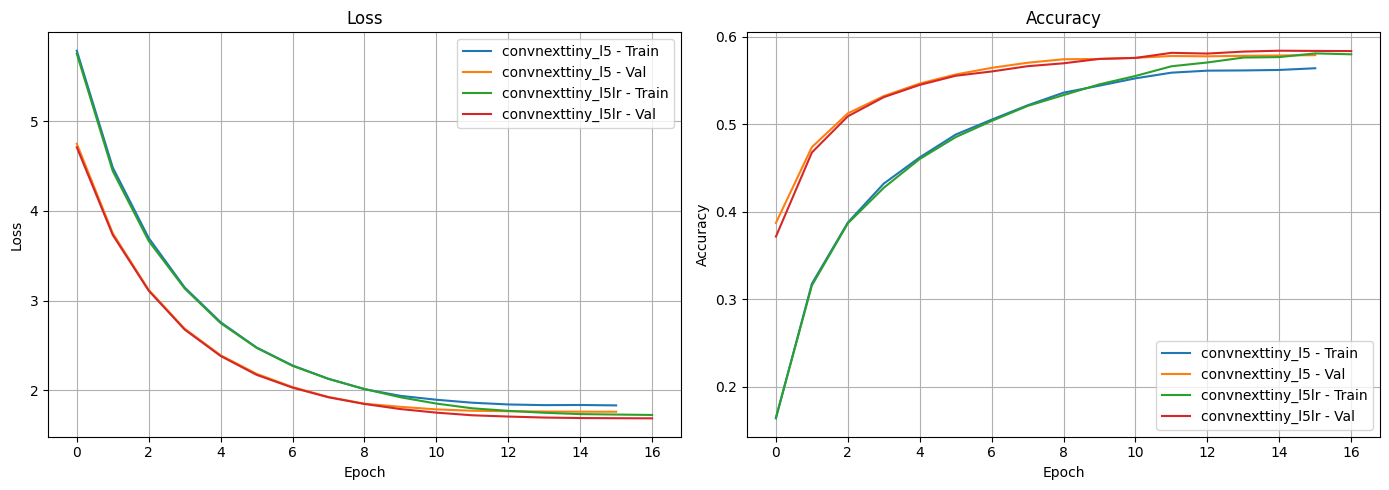

In [56]:
plot_history_comp(convnexttiny_l5, convnexttiny_l5lr,
                      model1_name="convnexttiny_l5",
                      model2_name="convnexttiny_l5lr")

## DenseNet201 L5

In [89]:
from tensorflow.keras.applications import DenseNet201

def create_datasets_densenet(base_path, train_df, val_df, batch_size):
    def preprocess_image(imageid, productid, label, augmented):
        def _load_image(image_path):
            img = tf.io.read_file(image_path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, [224, 224])
            img = tf.keras.applications.densenet.preprocess_input(img)
            return img

        image_path = tf.strings.join([
            base_path,
            "image_",
            imageid,
            "_product_",
            productid,
            ".jpg"
        ])

        image = _load_image(image_path)

        def apply_augmentation(img):
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, max_delta=0.1)
            translations = tf.cast(tf.random.uniform([2], -10, 10), tf.int32)
            img = tf.roll(img, shift=translations[0], axis=0)  # vertical shift
            img = tf.roll(img, shift=translations[1], axis=1)  # horizontal shift
            return img

        image = tf.cond(augmented, lambda: apply_augmentation(image), lambda: image)

        return image, label

    # Prepare train dataset with augmentation flags from train_df
    train_image_ids = train_df["imageid"].astype(str).values
    train_product_ids = train_df["productid"].astype(str).values
    train_labels = train_df["label"].values
    train_aug_flags = train_df["augmented"].astype(bool).values

    train_ds = tf.data.Dataset.from_tensor_slices(
        (train_image_ids, train_product_ids, train_labels, train_aug_flags)
    )
    train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Prepare validation dataset (no augmentation)
    val_image_ids = val_df["imageid"].astype(str).values
    val_product_ids = val_df["productid"].astype(str).values
    val_labels = val_df["label"].values
    val_aug_flags = [False] * len(val_df)

    val_ds = tf.data.Dataset.from_tensor_slices(
        (val_image_ids, val_product_ids, val_labels, val_aug_flags)
    )
    val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds

In [90]:
train_ds, val_ds = create_datasets_densenet(base_path, df_train_balanced, val_df, 128)

In [ ]:
# Model definition
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

for layer in base_model.layers[-5:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

densenet201_l5 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

densenet201_l5.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Callbacks

checkpoint = ModelCheckpoint(
    'densenet201_l5_best_model.keras',               
    monitor='val_loss',             
    mode='min',                     
    save_best_only=True,            
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.02,
    restore_best_weights=True
)

learning_rate =  ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=1,
        min_delta=0.1,
        min_lr=1e-7,
        verbose=1
)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [92]:
print("Model architecture:")
convnexttiny_l5.summary()

Model architecture:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_tiny (Functional)      │ (None, 7, 7, 768)      │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 768)            │         3,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 27)             │         1,755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,876,339 (125.41 MB)

 Trainable params: 2,472,347 (9.43 MB)

 Non-trainable params: 25,459,296 (97.12 MB)

 Optimizer params: 4,944,696 (18.86 MB)

In [93]:
import time
start_time = time.time()
# Train
densenet201_l5_history = densenet201_l5.fit(train_ds,
          validation_data=val_ds,
          epochs=20,
          callbacks=[early_stop, checkpoint, learning_rate])

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_min = elapsed_time / 60
print(f"Training time: {elapsed_time_min:.2f} min")

Epoch 1/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 5.8765 - sparse_categorical_accuracy: 0.0986
Epoch 1: val_loss improved from inf to 3.92026, saving model to densenet201_l5_best_model.keras
557/557 ━━━━━━━━━━━━━━━━━━━━ 176s 226ms/step - loss: 5.8752 - sparse_categorical_accuracy: 0.0987 - val_loss: 3.9203 - val_sparse_categorical_accuracy: 0.3795 - learning_rate: 1.0000e-04
Epoch 2/20
556/557 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 3.9481 - sparse_categorical_accuracy: 0.2790
Epoch 2: val_loss improved from 3.92026 to 3.14750, saving model to densenet201_l5_best_model.keras
557/557 ━━━━━━━━━━━━━━━━━━━━ 61s 109ms/step - loss: 3.9475 - sparse_categorical_accuracy: 0.2791 - val_loss: 3.1475 - val_sparse_categorical_accuracy: 0.4554 - learning_rate: 1.0000e-04
Epoch 3/20
556/557 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 3.3127 - sparse_categorical_accuracy: 0.3516
Epoch 3: val_loss improved from 3.14750 to 2.73851, saving model to densenet201_l5_best_model.keras
557/557 ━━━━

## DenseNet201 L5 LRc

In [ ]:
# Model definition
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

for layer in base_model.layers[-5:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

densenet201_l5lr = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

densenet201_l5lr.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Callbacks

checkpoint = ModelCheckpoint(
    'densenet201_l5lr_best_model.keras',               
    monitor='val_loss',            
    mode='min',                    
    save_best_only=True,            
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.02,
    restore_best_weights=True
)

learning_rate =  ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_delta=0.05,
        min_lr=1e-7,
        verbose=1
)

In [1]:
import time
start_time = time.time()

densenet201_l5lr_history = densenet201_l5lr.fit(train_ds,
          validation_data=val_ds,
          epochs=20,
          callbacks=[early_stop, checkpoint, learning_rate])

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_min = elapsed_time / 60
print(f"Training time: {elapsed_time_min:.2f} min")


KeyboardInterrupt



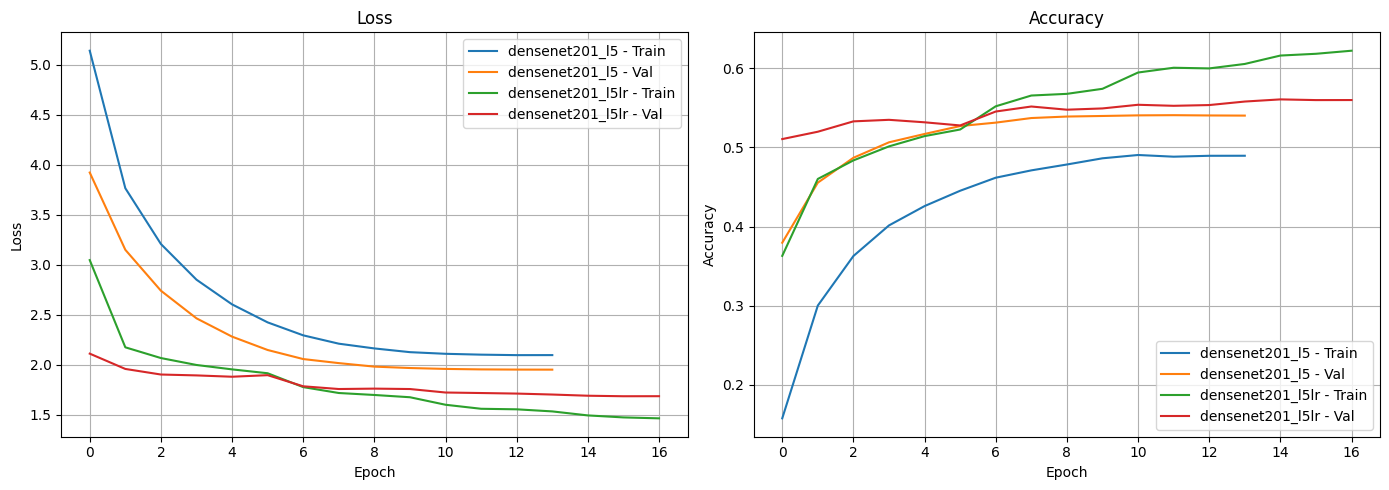

In [98]:
plot_history_comp(densenet201_l5, densenet201_l5lr,
                      model1_name="densenet201_l5",
                      model2_name="densenet201_l5lr")

## From scratch

In [57]:

def create_datasets_generic(base_path, train_df, val_df, batch_size):
    def preprocess_image(imageid, productid, label, augmented):
        def _load_image(image_path):
            img = tf.io.read_file(image_path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, [224, 224])
            return img

        image_path = tf.strings.join([
            base_path,
            "image_",
            imageid,
            "_product_",
            productid,
            ".jpg"
        ])

        image = _load_image(image_path)

        def apply_augmentation(img):
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, max_delta=0.1)
            translations = tf.cast(tf.random.uniform([2], -10, 10), tf.int32)
            img = tf.roll(img, shift=translations[0], axis=0)  # vertical shift
            img = tf.roll(img, shift=translations[1], axis=1)  # horizontal shift
            return img

        image = tf.cond(augmented, lambda: apply_augmentation(image), lambda: image)

        return image, label

    # Prepare train dataset with augmentation flags from train_df
    train_image_ids = train_df["imageid"].astype(str).values
    train_product_ids = train_df["productid"].astype(str).values
    train_labels = train_df["label"].values
    train_aug_flags = train_df["augmented"].astype(bool).values

    train_ds = tf.data.Dataset.from_tensor_slices(
        (train_image_ids, train_product_ids, train_labels, train_aug_flags)
    )
    train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Prepare validation dataset (no augmentation)
    val_image_ids = val_df["imageid"].astype(str).values
    val_product_ids = val_df["productid"].astype(str).values
    val_labels = val_df["label"].values
    val_aug_flags = [False] * len(val_df)

    val_ds = tf.data.Dataset.from_tensor_slices(
        (val_image_ids, val_product_ids, val_labels, val_aug_flags)
    )
    val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds

In [58]:
train_ds, val_ds = create_datasets_generic(base_path, df_train_balanced, val_df, 128)

In [83]:
cnn_from_scratch = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01), input_shape=(224,224,3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    # Block 3
    layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    #Block 4
    layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    # Classification Head
    layers.Flatten(),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [ ]:
cnn_from_scratch.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Callbacks

checkpoint = ModelCheckpoint(
    'cnn_from_scratch_best_model.keras',                
    monitor='val_loss',             
    mode='min',                    
    save_best_only=True,            
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.02,
    restore_best_weights=True
)

learning_rate =  ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_delta=0.05,
        min_lr=1e-7,
        verbose=1
)

In [80]:
print("Model architecture:")
cnn_from_scratch.summary()

Model architecture:


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 26,096,859 (99.55 MB)

 Trainable params: 26,094,875 (99.54 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
import time
start_time = time.time()

cnn_from_scratch_history = cnn_from_scratch.fit(train_ds,
          validation_data=val_ds,
          epochs=20,
          callbacks=[early_stop, checkpoint, learning_rate])

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time_min = elapsed_time / 60
print(f"Training time: {elapsed_time_min:.2f} min")

Epoch 1/20
557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 7.5557 - sparse_categorical_accuracy: 0.1998
Epoch 1: val_loss improved from inf to 6.17652, saving model to cnn_from_scratch_best_model.keras
557/557 ━━━━━━━━━━━━━━━━━━━━ 49s 73ms/step - loss: 7.5515 - sparse_categorical_accuracy: 0.1999 - val_loss: 6.1765 - val_sparse_categorical_accuracy: 0.0319 - learning_rate: 0.0010
Epoch 2/20
556/557 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 4.0555 - sparse_categorical_accuracy: 0.2838
Epoch 2: val_loss did not improve from 6.17652
557/557 ━━━━━━━━━━━━━━━━━━━━ 33s 59ms/step - loss: 4.0550 - sparse_categorical_accuracy: 0.2838 - val_loss: 6.5164 - val_sparse_categorical_accuracy: 0.0311 - learning_rate: 0.0010
Epoch 3/20
556/557 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 3.6656 - sparse_categorical_accuracy: 0.3194
Epoch 3: val_loss did not improve from 6.17652

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
557/557 ━━━━━━━━━━━━━━━━━━━━ 33s 59ms/step - loss: 

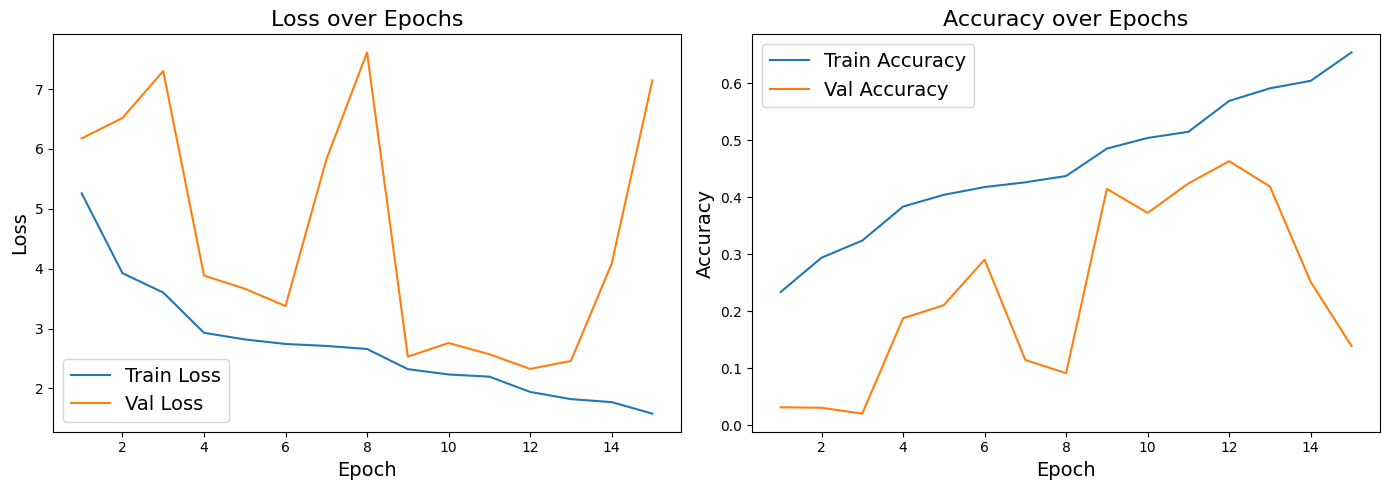

In [86]:
plot_history(cnn_from_scratch_history.history)

In [87]:
cnn_from_scratch_history.history

{'loss': [5.258408546447754,
  3.92529296875,
  3.6016018390655518,
  2.9295949935913086,
  2.818491220474243,
  2.743262767791748,
  2.7099406719207764,
  2.6593964099884033,
  2.322327136993408,
  2.2338664531707764,
  2.196995258331299,
  1.9424782991409302,
  1.8218333721160889,
  1.7718603610992432,
  1.5791401863098145],
 'sparse_categorical_accuracy': [0.23425890505313873,
  0.2942597568035126,
  0.3243303894996643,
  0.3839379847049713,
  0.4045422077178955,
  0.41818001866340637,
  0.4265509247779846,
  0.43760445713996887,
  0.4856388568878174,
  0.5043469667434692,
  0.5150914788246155,
  0.5693478584289551,
  0.5913987755775452,
  0.6045730710029602,
  0.6544193029403687],
 'val_loss': [6.176519870758057,
  6.516442775726318,
  7.300868034362793,
  3.8854782581329346,
  3.6656477451324463,
  3.376546621322632,
  5.820057392120361,
  7.612295627593994,
  2.5315091609954834,
  2.7593069076538086,
  2.5716335773468018,
  2.3266823291778564,
  2.4586260318756104,
  4.0812249183

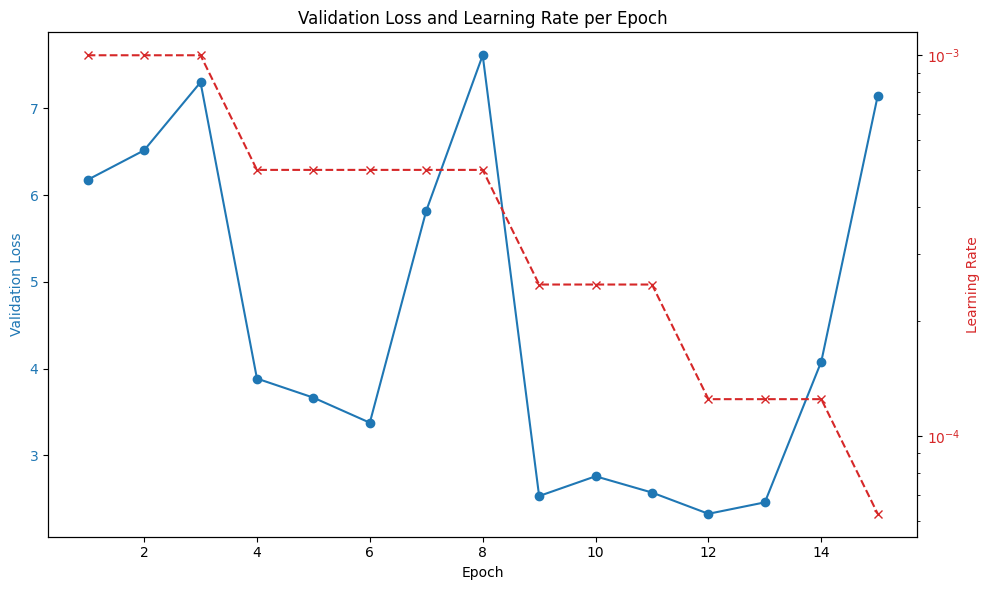

In [ ]:
val_loss = cnn_from_scratch_history.history['val_loss']
learning_rate = cnn_from_scratch_history.history.get('learning_rate')

epochs = range(1, len(val_loss) + 1)

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Loss', color=color)
ax1.plot(epochs, val_loss, marker='o', linestyle='-', color=color, label='Val Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Learning Rate', color=color)
ax2.plot(epochs, learning_rate, marker='x', linestyle='--', color=color, label='Learning Rate')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

plt.title('Validation Loss and Learning Rate per Epoch')
fig.tight_layout()
plt.show()

## Save histories

In [ ]:
import json
all_histories = {
    name: obj.history
    for name, obj in globals().items()
    if name.endswith('_history') and hasattr(obj, 'history')
}

for name, history_dict in all_histories.items():
    with open(f"{name}.json", "w") as f:
        json.dump(history_dict, f)

In [ ]:
import os
import zipfile
from google.colab import files

keras_files = [f for f in os.listdir('.') if f.endswith('.keras')]

with zipfile.ZipFile('keras_models.zip', 'w') as zipf:
    for file in keras_files:
        zipf.write(file)

files.download('keras_models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>